# Решение задачи классификации текстов по сантименту при помощи нейронных сетей (и логистической регрессии)

### Эпиграф

Будучи глубоко неудовлетворен теми результатами, которых позволяла достичь линейная и логистическая регрессия, я решил отложить сдачу финального проекта до тех пор, пока не обучусь нейросетям. Т.к. в настоящей специализации они проходились, я считаю такое решение задачи нейросетями совершенно легитимным.


In [ ]:
!pip install nltk

#Если нужно проверить мои модели нейронных сетей (не оправдавшиеся), то
!pip install tensorflow
#Также нужно скачать файл для GloVE http://nlp.stanford.edu/data/glove.6B.zip

In [2]:
#1. Импортируем общие библиотеки.
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rookie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#2. Импортируем тензорфлоу и керас
#Рассчитано на TF 2.0^

import tensorflow as tf
print(tf.__version__)
import keras
import keras.backend as K
import keras.layers as L
import tensorflow.compat.v1 as v1
np.random.seed(42)

#Функция очистки сессии
def reset_tf_session():
    curr_session = v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = v1.InteractiveSession(config=config)
    v1.keras.backend.set_session
    return s

reset_tf_session()

2.3.0


In [4]:
#3. Готовим первичные выборки, разбиваем тексты на слова с помощью nltk.tokenize, делаем словарь (для нейросетей)
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

df = pd.read_csv("products_sentiment_train.tsv", sep='\t', header=None)
df.columns = ["text", "label"]

X = [x[0] for x in df[["text"]].values.tolist()]   #Выборка, где элемент - строка 
Y = [y[0] for y in df[["label"]].values.tolist()]

df = pd.read_csv("products_sentiment_test.tsv", sep='\t')
Xv = [x[0] for x in df[["text"]].values.tolist()]

#Токенизируем список строк
def tokenize_texts(texts):
    return [word_tokenize(text) for text in texts]

#Готовим словарь
#Плоский список из текстов
flat_list = [item for sublist in tokenize_texts(X) for item in sublist]
#Список уникальных слов из выборки
all_words = list(set(flat_list))

del flat_list
UNK = "#UNK" #Символ "неизвестное слово", будет кодироваться нулем или нулевым вектором

all_words = [UNK] + all_words
vocab = {word: idx for idx, word in enumerate(all_words)}

len(X), len(Y), len(Xv), len(all_words), len(vocab), (X[0], tokenize_texts(X[0:1]))

(2000,
 2000,
 500,
 4188,
 4188,
 ('2 . take around 10,000 640x480 pictures .',
  [['2', '.', 'take', 'around', '10,000', '640x480', 'pictures', '.']]))

In [ ]:
#3.1. Создаем пайплайн для логистической регрессии - бейслайн
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()
classifier = LogisticRegression(solver='lbfgs')
pipeline = Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])

pipeline.fit(X, Y)

In [14]:
#4.1 Функции для работы модели 1 и 3
from keras.preprocessing.sequence import pad_sequences

#Размер батча
N_BATCH = 4

#Преобразуем строку в последовательность - для варианта с СОБСТВЕННЫМ СЛОВАРЕМ
def to_sequence(text):
    return np.array([vocab[w] if w in vocab else vocab[UNK] for w in word_tokenize(text)])

#Преобразуем последовательность в текст (строку) - для варианта с СОБСТВЕННЫМ СЛОВАРЕМ
def to_text(seq):
    return ' '.join([vocab_inverse[idx] if idx in vocab_inverse else UNK for idx in seq])

#Преобразуем список текстов в список последовательностей - для варианта с СОБСТВЕННЫМ СЛОВАРЕМ
def to_sequences(texts):
    return [to_sequence(text) for text in texts]

#Преобразуем список текстов в numpy матрицу последовательностей формы (<колво текстов>, <длина самого длинного из них>). 
#Последовательности в матрице дополняем нулями справа до нужной длины. Строк полностью из нулей быть не должно.
#Пример
#Словарь: {'A': 1, 'B': 2, 'C': 3}
#Тексты:  
#[['A B B C'], ['B C A']]
#На выходе матрица 
#[[1, 2, 2, 3],
# [2, 3, 1, 0]]
def to_matrix(texts, maxlen=0): #- для варианта с СОБСТВЕННЫМ СЛОВАРЕМ
    seqs = to_sequences(texts)
    if maxlen == 0:
        maxlen = min(9999, max(list(map(len, seqs))))
    return pad_sequences(seqs, maxlen=maxlen, dtype='int32', padding='post', truncating='post', value=0)

#Выбираем из исходных выборок батч заданной длины, X прогоняем через to_matrix, Y просто преобразуем к формату numpy
#Эта функция не применяется, т.к. достаточно памяти для загрузки всех данных сразу
def get_batch(x, y, count=N_BATCH):
    offset = 0
    while True:        
        X_batch = to_matrix(x[offset:offset+count])
        Y_batch = np.array(y[offset:offset+count])
        yield X_batch, Y_batch
        offset += count
        if offset >= len(X)//count*count:
            offset = 0
            
to_matrix(X[0:5])

array([[1127, 2031, 3917, 2857,  476, 3961, 3112, 2031,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [3430,  224, 1836, 4001, 1479, 4026,  378, 1893, 1250,  317,  691,
        1735,  691, 2494, 3648,  414, 3046, 1836,  378,  175,  736, 2303,
        3985,  470, 2031,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 347, 4039, 1185,  347,  801, 2620, 1836, 1911, 1186, 2101, 3106,
        2157, 2814, 3780, 3648, 1836, 3319, 4061, 2511, 3186, 1836, 2358,
        1271, 2852, 3475, 1388, 2086, 2031,    0,    0,    0,    0,    0],
       [3430,   62, 1289, 3892, 3390, 1121, 1347,  227,  388, 2304, 1625,
        1072,  227, 1404, 3723, 2317, 2605, 2594, 3046, 2856, 1560, 4139,
        3892, 3106,  513, 3703, 3648,  965,  532,  560,  691,  115, 2031],
       [3430, 3475,  996,  347, 4180, 2694, 3252,  691,  383, 2705, 3433,
         629,  347,  386, 1302, 24

In [ ]:
#4.2. Функции для модели 2: строим эмбеддинг на основе TfIdf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

def tokenize_texts(texts):
    return [tokenize(text) for text in texts]

flat_list = [item for sublist in tokenize_texts(X) for item in sublist]
#Список уникальных слов из выборки
all_words = list(set(flat_list))


tfidf = TfidfVectorizer(tokenizer=tokenize, use_idf=True)
tfs = tfidf.fit_transform(all_words)

del flat_list; del all_words

def embed(texts):
    return tfidf.transform(texts).todense()

embed(['I love you', 'I hate you']).shape

#Результаты моделирования очень разочаровывают

In [28]:
#4.3. Функции для модели 3: строим эмбеддинг на основе GloVE
EMBEDDING_DIM = 50

#Разбиваем готовые векторизации на слова и коэффициенты
embeddings_index = {}
with open('glove.6B.50d.txt', 'r', encoding="UTF-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
#Готовим матрицу коэффициентов
embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        #В противном случае (неизвестные GloVe слова будут отображены нулевым вектором)

embedding_layer = L.Embedding(len(vocab),
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], trainable=False, mask_zero=True)



In [ ]:
#5.1. Модель 1 - дает точность 0.7666
N_EMBED = 16
N_LSTM = 512

#Используем оптимизатор Adam и бинарную кроссэнтропию в качестве функции потерь
def build_model():
    #Input - входные данные, шейп (None, None) означает, что мы можем принимать батч произвольной длины 
    X = L.Input(batch_input_shape=(N_BATCH,None))
    #Embedding - обеспечивает выравнивание входных данных и компактное представление одного элемента последовательности в 16 числах
    e = L.Embedding(len(vocab), N_EMBED, mask_zero=True, name="e")(X)
    #LSTM - Long Short Term Memory - обеспечивает анализ последовательности
    l1 = L.LSTM(units=N_LSTM, return_sequences=True, name="l1", dropout=0.25)(e)
    l2 = L.LSTM(units=N_LSTM, return_sequences=False, name="l2", dropout=0.25)(l1)
    #Выходной слой обеспечивает сворачивание в бинарное значение, активация на выходном слое сигмоиду для значения [0..1]
    Y = L.Dense(1, name="d3", activation="sigmoid")(l2)
    return keras.models.Model(inputs=X, outputs=Y)

t_model = build_model()
opt = keras.optimizers.Adam(lr=0.0001)
t_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
t_model.summary()

In [ ]:
#5.2. Модель 2 с TF-IDF эмбеддингом и обходимся без LSTM - дает еще плохие результаты

def build_model():
    x = L.Input(batch_input_shape=(4, 3236))
    d1 = L.Dense(512, name="d1", activation="relu")(x)
    y = L.Dense(1, name="d2", activation="sigmoid")(d1)
    return keras.models.Model(inputs=x, outputs=y)

t_model = build_model()
opt = keras.optimizers.Adam(lr=0.0001)
t_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
t_model.summary()    

In [52]:
#5.3. Модель 3
N_LSTM = 1024
N_BATCH = 4

#Используем оптимизатор Adam и бинарную кроссэнтропию в качестве функции потерь
def build_model():
    #Input - входные данные, шейп (None, None) означает, что мы можем принимать батч произвольной длины 
    X = L.Input(batch_input_shape=(None, None))
    #Пользуемся заранее подготовленным эмбеддингом GloVe
    e = embedding_layer(X)
    l1 = L.LSTM(units=N_LSTM, return_sequences=False)(e)
    d = L.Dense(256, activation="relu")(l1)
    d = L.Dropout(0.2)(d)
    d = L.Dense(16, activation="relu")(d)
    d = L.Dropout(0.2)(d)
    Y = L.Dense(1, activation="sigmoid")(d)
    return keras.models.Model(inputs=X, outputs=Y)

t_model = build_model()
opt = keras.optimizers.Adam(lr=0.0001)
t_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
t_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        multiple                  209400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              4403200   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [57]:
#Функции для тренировки моделей
#до третьей эпохи шаг обучения 0.0001 затем начинает уменшаться
def _schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#Вариант с генератором
def train_model_gen(xt, yt, initial_epoch=0, n_epochs=10):
    t_model.fit(get_batch(xt, yt), epochs=n_epochs, steps_per_epoch=len(xt)//N_BATCH,
                shuffle=True, initial_epoch=initial_epoch, validation_data=(to_matrix(Xv), np.array(Yv)),
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint(filepath='./W3/model.{epoch:03d}.hdf5'),
                    tf.keras.callbacks.LearningRateScheduler(_schedule)
                ])
#Вариант с целиковой обработкой - используем Коллбэки для сохранения модели, уменшения шага обучения и перетасовки
def train_model_1_3(xt, yt, initial_epoch=0, n_epochs=10):
    t_model.fit(to_matrix(xt), np.array(yt), epochs=n_epochs, shuffle=True, batch_size=N_BATCH,
                initial_epoch=initial_epoch, #validation_data=(to_matrix(Xv), np.array(Yv)),\
                callbacks=[
                    #tf.keras.callbacks.LearningRateScheduler(_schedule)
                ])
    
def train_model_2(initial_epoch=0, n_epochs=10):
    t_model.fit(embed(Xt), np.array(Yt), epochs=n_epochs, shuffle=True, batch_size=N_BATCH,
                initial_epoch=initial_epoch, validation_data=(embed(Xv), np.array(Yv)),\
                callbacks=[
                    tf.keras.callbacks.LearningRateScheduler(_schedule)
                ])  


In [58]:
#reset_tf_session()

#opt = keras.optimizers.Adam(lr=0.0001)
#t_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])

train = train_model_1_3

#Считаем по 10 эпох, потом перетасовываем трейн и валидацию
train(X, Y, 0, 20)

Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4823 - accuracy: 0.7630
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4728 - accuracy: 0.7770 1s - loss: 0.4669 - accura
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4530 - accuracy: 0.7880
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4337 - accuracy: 0.8000
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4151 - accuracy: 0.7965
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3960 - accuracy: 0.8115
Epoch 7/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3897 - accuracy: 0.8155
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3645 - accuracy: 0.8290
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3428 - accuracy: 0.8445
Epoch 10/20
500/500 [==============================] - 9s 17ms/s

In [59]:
df = pd.read_csv("products_sentiment_test.tsv", sep='\t')
X_test = [x[0] for x in df[["text"]].values.tolist()]

Y_pred = [ 0 if y < 0.5 else 1 for y in t_model.predict(to_matrix(X_test))]
len(X_test), len(Y_pred)

(500, 500)

### Disclaimer
На этом моменте следует остановиться и объявить что пока что мое применение нейросетей дало совсем неутешительные результаты.
Модель 1 получила точность на проверке 0.7666
Модель 2 получила мало отличимую от 0.5 точность
Модель 3, на которую возлагались надежды, получила точность 0.72
Обычная логистическая регрессия же дает 0.7777, код приложен ниже.

Следует признать свое разочарование и учесть, что что-то важное я упускаю при построении моделей с нейронными сетями.

In [62]:
#Модель 5.4 LogisticRegression() :)))))))))))))))))))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()
classifier = LogisticRegression(solver='lbfgs')
pipeline = Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
pipeline.fit(X, Y)

Y_pred = pipeline.predict(X_test)

In [63]:
df = pd.DataFrame()
df["y"] = Y_pred
df.head()

df.to_csv("kaggle_submission.csv", sep=',', index_label="Id")

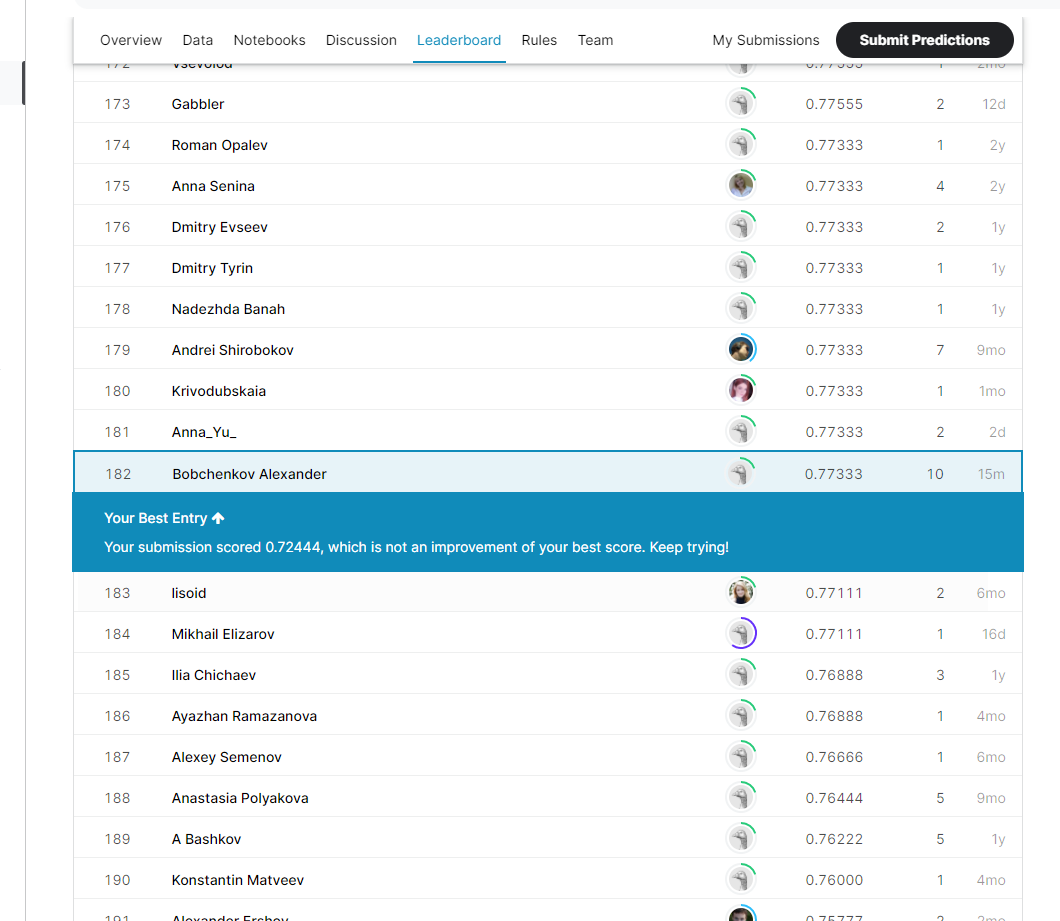

In [64]:
from IPython.display import Image

Image(filename = 'screen.png')